## Ehecución Google Colab

In [ ]:
import numpy as np
import pickle
import gdown
import os
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import TensorDataset
import os
from google.colab import drive,output

In [ ]:
drive.mount('/content/drive')
# !ln -s "/content/drive/MyDrive/ZTF"
# os.chdir("./ZTF")
# print("Current working directory: {0}".format(os.getcwd()))

Mounted at /content/drive


## Lectura

In [ ]:
with open('/content/drive/MyDrive/proyecto/Codigos/baseRecurrente.npy', 'rb') as f:
    data_train = np.load(f)
    train_label = np.load(f)
    data_val = np.load(f)
    val_label = np.load(f)
    data_test = np.load(f)
    test_label = np.load(f)

## Balance de datos

In [ ]:
from collections import Counter
print(Counter(val_label).keys())
print(Counter(val_label).values())

dict_keys([2.0, 0.0, 1.0])
dict_values([2473, 1310, 75])


In [ ]:
filtro2=(train_label==2)
filtro1=(train_label==1)
filtro0=(train_label==0)

In [ ]:
label0=train_label[filtro0][:1352]
label1=train_label[filtro1][:1352]
label2=train_label[filtro2][:1352]

data0=data_train[filtro0][:1352]
data1=data_train[filtro1][:1352]
data2=data_train[filtro2][:1352]
data_train=np.concatenate((data0, data1,data2), axis=0)
train_label=np.concatenate((label0, label1,label2), axis=0)

In [ ]:
print(np.shape(data_train))
print(np.shape(train_label))

(4056, 3, 128)
(4056,)


In [ ]:
print(Counter(train_label).keys())
print(Counter(train_label).values())

dict_keys([0.0, 1.0, 2.0])
dict_values([1352, 1352, 1352])


In [ ]:
filtro2=(val_label==2)
filtro1=(val_label==1)
filtro0=(val_label==0)

In [ ]:
label0=val_label[filtro0][:75]
label1=val_label[filtro1][:75]
label2=val_label[filtro2][:75]

data0=data_val[filtro0][:75]
data1=data_val[filtro1][:75]
data2=data_val[filtro2][:75]
data_val=np.concatenate((data0, data1,data2), axis=0)
val_label=np.concatenate((label0, label1,label2), axis=0)

In [ ]:
print(np.shape(data_val))
print(np.shape(val_label))

(225, 3, 128)
(225,)


In [ ]:
print(Counter(val_label).keys())
print(Counter(val_label).values())

dict_keys([0.0, 1.0, 2.0])
dict_values([75, 75, 75])


In [ ]:
filtro2=(test_label==2)
filtro1=(test_label==1)
filtro0=(test_label==0)

In [ ]:
label0=test_label[filtro0][:75]
label1=test_label[filtro1][:75]
label2=test_label[filtro2][:75]

data0=data_test[filtro0][:75]
data1=data_test[filtro1][:75]
data2=data_test[filtro2][:75]
data_test=np.concatenate((data0, data1,data2), axis=0)
test_label=np.concatenate((label0, label1,label2), axis=0)

## Creación de dataset

In [ ]:

my_datatrain = TensorDataset(torch.Tensor(data_train),torch.Tensor(train_label)) 
my_dataval = TensorDataset(torch.Tensor(data_val),torch.Tensor(val_label))
my_datatest = TensorDataset(torch.Tensor(data_test),torch.Tensor(test_label))

## Arquitectura

In [ ]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,num_classes):
        super(RNN, self).__init__()
        self.num_layers=num_layers
        self.hidden_size=hidden_size

        self.rnn=nn.GRU(input_size,hidden_size,num_layers,batch_first=True)
        self.fc=nn.Sequential(nn.Linear(hidden_size,64),
                                nn.Dropout(p=0.3),
                                nn.ReLU(),
                                nn.Linear(64,32),
                                nn.ReLU(),
                                nn.Linear(32,16),
                                nn.ReLU(),
                                nn.Linear(16,num_classes)
                            )

    
    def forward(self, x,gpu):
        if gpu== True:

            h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).cuda()
        else:
            h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size)

        out,_=self.rnn(x,h0)
        out=out[:,-1,:]
        out=self.fc(out)
        return out

In [ ]:
import matplotlib.pyplot as plt
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

## Entrenamiento

In [ ]:
input_size=128
hidden_size=16
num_classes=3
num_epoch=30
batch_size=16
lr=1e-4
num_layers=2
    

model=RNN(input_size,hidden_size,num_layers,num_classes)  
criterion= nn.CrossEntropyLoss() # Probar con Cross entropy
optimizer=torch.optim.Adam(model.parameters(),lr=lr) # Probar con Sgd



current_loss=0

use_gpu=True

train_loader = torch.utils.data.DataLoader(my_datatrain, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
val_loader = torch.utils.data.DataLoader(my_dataval, batch_size=len(my_dataval), shuffle=False, pin_memory=use_gpu)
num_total_steps=len(train_loader)
curves = {
    "train_acc": [],
    "val_acc": [],
    "train_loss": [],
    "val_loss": []
}
if use_gpu:
    model.cuda()

for epoch in range(num_epoch):
    acumulado=0
    train_acc_count=0
    val_acc_count=0

    cumulative_train_corrects=0

    model.train()   
    for i, (x_batch, y_batch) in enumerate(train_loader):
        largo=len(x_batch)
        # print(np.shape(x_batch))
        if use_gpu:
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()

        outputs=model(x_batch,use_gpu)

        if use_gpu:
            y_batch = y_batch.type(torch.LongTensor).cuda()
        else:
            y_batch = y_batch.type(torch.LongTensor)

        class_prediction = torch.argmax(outputs, axis=1).long()
        train_acc_count += y_batch.shape[0]
        cumulative_train_corrects += (y_batch == class_prediction).sum().item()

        loss=criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acumulado+=loss.item()
        
    acc_train=cumulative_train_corrects / train_acc_count
    train_loss=acumulado/num_total_steps
    print(f"Epoch [{epoch+1}/{num_epoch}], Loss:{train_loss:.4f}, acc train: {acc_train:.4f}")

    model.eval()
    with torch.no_grad():
        val_acc_count=0
        cumulative_val_corrects=0
        for x_val, y_val in val_loader:
            if use_gpu:
                x_val = x_val.cuda()
                y_val = y_val.cuda()

            y_predicted = model(x_val,use_gpu)
            if use_gpu:
                y_val = y_val.type(torch.LongTensor).cuda()
            else:
                y_val = y_val.type(torch.LongTensor)
            loss_val=criterion(y_predicted, y_val)

            class_prediction = torch.argmax(y_predicted, axis=1).long()
            val_acc_count += y_val.shape[0]
            cumulative_val_corrects += (y_val == class_prediction).sum().item()

    acc_val=cumulative_val_corrects / val_acc_count
    curves["train_acc"].append(acc_train)
    curves["val_acc"].append(acc_val)
    curves["train_loss"].append(train_loss)
    curves["val_loss"].append(loss_val.item())
    print(f"Epoch [{epoch+1}/{num_epoch}], Loss:{loss_val.item():.4f}, acc val: {cumulative_val_corrects / val_acc_count:.4f}")
model.cpu()

Epoch [1/30], Loss:1.1039, acc train: 0.3545
Epoch [1/30], Loss:1.0777, acc val: 0.4933
Epoch [2/30], Loss:0.9458, acc train: 0.5986
Epoch [2/30], Loss:0.8605, acc val: 0.6089
Epoch [3/30], Loss:0.7589, acc train: 0.7014
Epoch [3/30], Loss:0.7995, acc val: 0.6667
Epoch [4/30], Loss:0.7065, acc train: 0.7157
Epoch [4/30], Loss:0.7694, acc val: 0.6578
Epoch [5/30], Loss:0.6806, acc train: 0.7167
Epoch [5/30], Loss:0.7515, acc val: 0.6889
Epoch [6/30], Loss:0.6658, acc train: 0.7236
Epoch [6/30], Loss:0.7397, acc val: 0.6889
Epoch [7/30], Loss:0.6548, acc train: 0.7273
Epoch [7/30], Loss:0.7262, acc val: 0.7111
Epoch [8/30], Loss:0.6449, acc train: 0.7340
Epoch [8/30], Loss:0.7171, acc val: 0.6933
Epoch [9/30], Loss:0.6357, acc train: 0.7359
Epoch [9/30], Loss:0.7064, acc val: 0.7156
Epoch [10/30], Loss:0.6366, acc train: 0.7327
Epoch [10/30], Loss:0.7003, acc val: 0.7244
Epoch [11/30], Loss:0.6275, acc train: 0.7357
Epoch [11/30], Loss:0.6939, acc val: 0.7244
Epoch [12/30], Loss:0.6205, 

RNN(
  (rnn): GRU(128, 16, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=16, bias=True)
    (6): ReLU()
    (7): Linear(in_features=16, out_features=3, bias=True)
  )
)

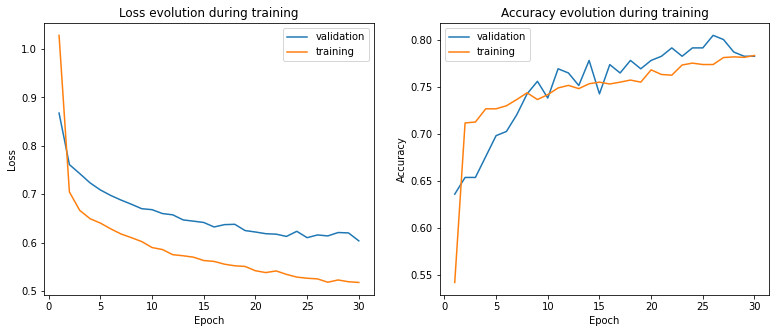

In [ ]:
show_curves(curves)

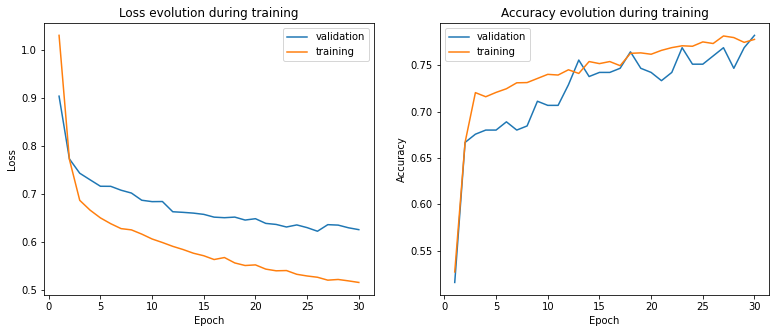

In [ ]:
show_curves(curves)

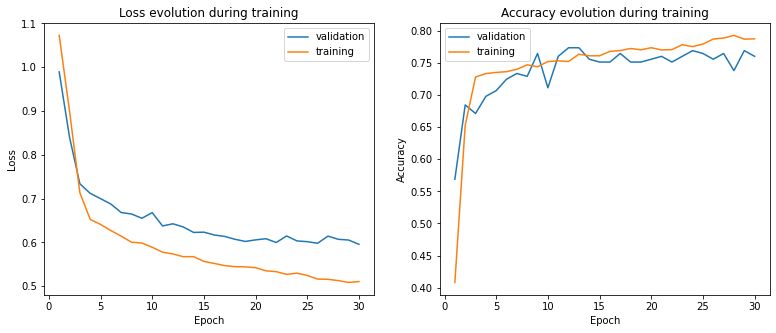

In [ ]:
show_curves(curves)

In [ ]:
input_size=128
hidden_size=32
num_classes=3
num_epoch=30
batch_size=64
lr=5e-4
num_layers=2
    

model=RNN(input_size,hidden_size,num_layers,num_classes) 
model.load_state_dict(torch.load('/content/Recurrente7.pth'))


<All keys matched successfully>

## Resultados

In [ ]:
test_loader = torch.utils.data.DataLoader(my_datatest, batch_size=len(my_datatest), shuffle=False, pin_memory=False)
model.eval()
with torch.no_grad():
    for x_test,y_test in test_loader:

        y_predicted = model(x_test,False)

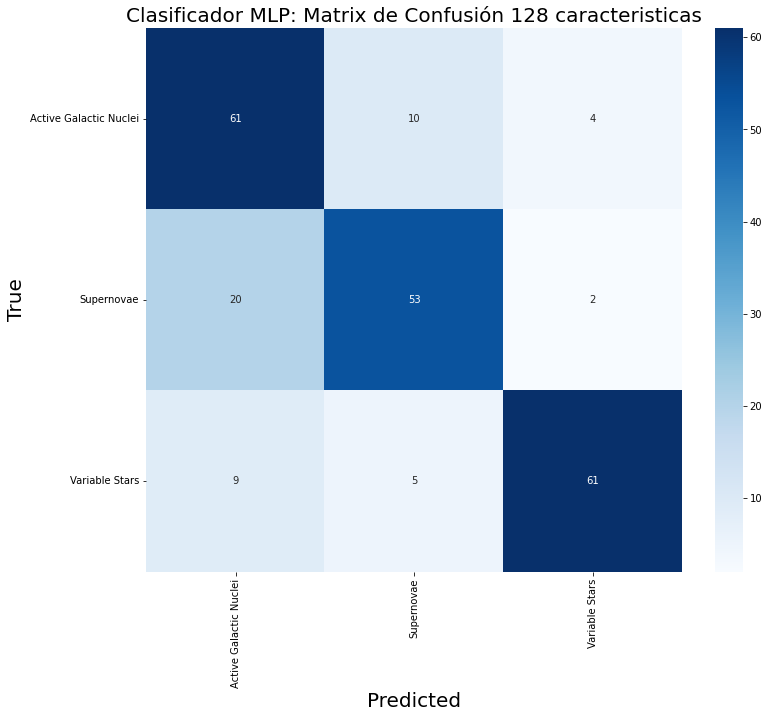

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# X_test=vector_test64
# predict=rbf_svc.predict(X_test)

class_prediction = torch.argmax(y_predicted, axis=1).long()
# https://stackoverflow.com/questions/65618137/confusion-matrix-for-multiple-classes-in-python


# labels = le.classes_
class_names =  ["Active Galactic Nuclei","Supernovae","Variable Stars"]

cm = confusion_matrix(y_test, class_prediction)
# cmn = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig = plt.figure(figsize=(12, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True,cmap="Blues", ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Clasificador MLP: Matrix de Confusión 128 caracteristicas', fontsize=20)

# plt.savefig('ConMat24.png')
plt.show()

In [ ]:
model.cpu()
torch.save(model.state_dict(),"Recurrente7.pth")

In [ ]:
input_size=128
hidden_size=32
num_classes=3
num_epoch=30
batch_size=8
lr=1e-4
num_layers=2
    

model=RNN(input_size,hidden_size,num_layers,num_classes)  

In [ ]:
torch.save(model.state_dict(),"/content/Recurrente6.pth")